TODO
- max_length = 
- batch_size = 
- label smoothing
- paramterize tokens with sentencepiece

# Boilerplate

In [1]:
import sys; sys.path.insert(0, '..')

# files
TRAINING_DIRECTORY = '../data/preprocessed_stories'
EXTENSION = '.clean'
N_TRAIN_FILES = 40000
N_TEST_FILES = 500
TOKENS_PER_BATCH = 4096

In [2]:
# show tensor2tensor hparams for summarization for reference
import tensor2tensor.models.transformer
from tensor2tensor.utils.registry import hparams
params = hparams('transformer_prepend')()
for k, v in sorted(vars(params).items(), key=lambda tup: tup[0]):
    if not k.startswith('_') and not callable(v):
        print(f'{k}={v!r}')

activation_dtype='float32'
attention_dropout=0.1
attention_dropout_broadcast_dims=''
attention_key_channels=0
attention_value_channels=0
batch_size=4096
clip_grad_norm=0.0
compress_steps=0
daisy_chain_variables=True
dropout=0.2
eval_drop_long_sequences=False
eval_run_autoregressive=False
factored_logits=False
ffn_layer='dense_relu_dense'
filter_size=2048
force_full_predict=False
grad_noise_scale=0.0
hidden_size=512
initializer='uniform_unit_scaling'
initializer_gain=1.0
input_modalities='default'
kernel_height=3
kernel_width=1
label_smoothing=0.1
layer_postprocess_sequence='da'
layer_prepostprocess_dropout=0.1
layer_prepostprocess_dropout_broadcast_dims=''
layer_preprocess_sequence='n'
learning_rate=0.2
learning_rate_constant=1.0
learning_rate_cosine_cycle_steps=250000
learning_rate_decay_rate=1.0
learning_rate_decay_scheme='noam'
learning_rate_decay_staircase=False
learning_rate_decay_steps=5000
learning_rate_minimum=None
learning_rate_schedule='legacy'
learning_rate_warmup_steps=8000

# Read in files

In [3]:
import glob

In [4]:
FILES = glob.glob('%s/*%s' % (TRAINING_DIRECTORY, EXTENSION))
print(len(FILES))
FILES

312085


['../data/preprocessed_stories/000064fee589e5607c1534a69f852d37b4936cca.clean',
 '../data/preprocessed_stories/0000800d9058217f6509d7e63ad475e2de0da611.clean',
 '../data/preprocessed_stories/0000bf554ca24b0c72178403b54c0cca62d9faf8.clean',
 '../data/preprocessed_stories/0000dfd9f52a470b9f29957686c2704b68cd0635.clean',
 '../data/preprocessed_stories/000128cbd36642ced67ac90bd7d4d1dd5e8cf554.clean',
 '../data/preprocessed_stories/0001d1afc246a7964130f43ae940af6bc6c57f01.clean',
 '../data/preprocessed_stories/0001d4ce3598e37f20a47fe609736f72e5d73467.clean',
 '../data/preprocessed_stories/0001dc22494415d03319a6833a00cd9c559f1395.clean',
 '../data/preprocessed_stories/0001f1fcec4ca8bc7e278607ba0e31e5cc046e66.clean',
 '../data/preprocessed_stories/0002067d13d3ca304e0bc98d04dde85d4091c55e.clean',
 '../data/preprocessed_stories/0002095e55fcbd3a2f366d9bf92a95433dc305ef.clean',
 '../data/preprocessed_stories/000219931d2c3aae55dc2acdc5f690d0c112ab17.clean',
 '../data/preprocessed_stories/00022dbfa

In [5]:
TRAIN_FILES = FILES[:N_TRAIN_FILES]
TEST_FILES = FILES[N_TRAIN_FILES:N_TRAIN_FILES+N_TEST_FILES]

# Define batch generator

# Initialize Tokenizer

In [6]:
import numpy as np
import sentencepiece as spm

class BytePairEncoder:
    def __init__(self, vocab_size, model_name, *, model_file=None, vocab_file=None,
                 training_file=None, processor=None, **kwargs):
        self.vocab_size = vocab_size
        self.model_name = model_name
        self.training_file = training_file
        self.model_file = f'{self.model_name}.model' if model_file is None else model_file
        self.vocab_file = f'{self.model_name}.vocab' if vocab_file is None else vocab_file
        if processor is None:
            if training_file is None:
                raise ValueError('training_file cannot be None when processor is also None.')
            processor = self._fit(input=training_file, vocab_size=vocab_size,
                                  model_prefix=model_name, model_type='bpe',
                                  **kwargs)
        self.processor = processor
        
    def encode(self, text):
        return np.array(self.processor.EncodeAsIds(text))
    
    def encode_as_pieces(self, text):
        return self.processor.EncodeAsPieces(text)
    
    def decode(self, ids):
        return self.processor.DecodeIds(ids.tolist())
    
    def decode_pieces(self, pieces):
        return self.processor.DecodePieces(pieces)

    @classmethod
    def from_files(cls, model_file, vocab_file):
        model_name = model_file.partition('.')[0]
        processor = cls._load_model(model_file)
        for vocab_size, _ in enumerate(open(vocab_file), start=1): pass
        return cls(vocab_size=vocab_size, model_name=model_name, processor=processor,
                   model_file=model_file, vocab_file=vocab_file)
        
    @staticmethod
    def _load_model(filename):
        processor = spm.SentencePieceProcessor()
        processor.Load(filename)
        return processor
        
    def _fit(self, **kwargs):
        params = ' '.join([f'--{k}={v}' for k, v in kwargs.items()])
        spm.SentencePieceTrainer.Train(params)
        processor = self._load_model(self.model_file)
        return processor

In [7]:
# trained in byte-pair-encoding
TOKENIZER = BytePairEncoder.from_files('summarizer.model', 'summarizer.vocab')

In [8]:
TOKENIZER.vocab_size

30000

# Tokenize files

In [9]:
class TrainingExample:
    """Simple container to keep track of training data. Useful for debugging."""
    def __init__(self, item, context_text, target_text, context_tokens,
                 target_tokens):
        self.item = item
        self.context_text = context_text
        self.target_text = target_text
        self.context_tokens = context_tokens
        self.target_tokens = target_tokens
        
    def __len__(self):
        return len(self.context_tokens) + len(self.target_tokens)

def load_files(files, tokenizer):
    """Load and tokenize files."""
    training_examples = []
    for file in files:
        with open(file) as f:
            context_text, target_text = f.read().split('\t')
        context_tokens = tokenizer(context_text)
        target_tokens = tokenizer(target_text)
        example = TrainingExample(file, context_text, target_text,
                                  context_tokens, target_tokens)
        training_examples.append(example)
    return training_examples

In [10]:
%%time
from tqdm import tqdm_notebook as tqdm
TRAINING_EXAMPLES = load_files(tqdm(TRAIN_FILES[:1000]), TOKENIZER.encode)
# sort files by number of tokens to reduce padding
TRAINING_EXAMPLES = sorted(TRAINING_EXAMPLES, key=lambda x: len(x))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


CPU times: user 3.49 s, sys: 71.1 ms, total: 3.56 s
Wall time: 3.64 s


In [11]:
[len(x) for x in TRAINING_EXAMPLES]

[28,
 134,
 147,
 171,
 176,
 181,
 182,
 205,
 209,
 221,
 224,
 233,
 237,
 240,
 243,
 251,
 251,
 255,
 266,
 266,
 266,
 277,
 280,
 280,
 281,
 283,
 284,
 290,
 295,
 296,
 299,
 300,
 305,
 306,
 310,
 314,
 314,
 324,
 326,
 328,
 328,
 331,
 335,
 340,
 340,
 340,
 342,
 345,
 351,
 353,
 360,
 360,
 362,
 363,
 368,
 368,
 370,
 370,
 372,
 372,
 373,
 374,
 374,
 374,
 375,
 375,
 376,
 377,
 377,
 378,
 379,
 381,
 383,
 386,
 387,
 388,
 390,
 390,
 392,
 393,
 393,
 394,
 394,
 395,
 396,
 396,
 397,
 400,
 401,
 401,
 408,
 408,
 408,
 409,
 409,
 418,
 419,
 419,
 420,
 424,
 424,
 426,
 427,
 427,
 428,
 428,
 428,
 431,
 431,
 432,
 437,
 438,
 439,
 441,
 442,
 443,
 443,
 444,
 445,
 446,
 447,
 447,
 450,
 451,
 452,
 452,
 453,
 453,
 454,
 455,
 457,
 460,
 461,
 462,
 463,
 463,
 464,
 466,
 470,
 470,
 471,
 474,
 476,
 476,
 479,
 482,
 482,
 482,
 482,
 482,
 483,
 487,
 489,
 491,
 491,
 496,
 497,
 497,
 497,
 498,
 498,
 499,
 499,
 499,
 500,
 503,
 503,

In [12]:
def compute_n_batches(examples, batch_size):
    s = 0
    c = 0
    for e in examples:
        s += len(e)
        if 0.95*batch_size <= s <= 1.05*batch_size:
            s = 0
            c += 1
    return c

In [13]:
compute_n_batches(TRAINING_EXAMPLES, TOKENS_PER_BATCH)

13

# Take a look at batches

In [51]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

import sys; sys.path.append('..')
from data import BaseBatchGenerator


class SummaryBatchGenerator(BaseBatchGenerator):
    def __init__(self, max_context_len=None, max_target_len=None, eos_token=-1,
                 pad_token=0, prepend=True):
        self.max_context_len = max_context_len
        self.max_target_len = max_target_len
        self.eos_token = eos_token
        self.pad_token = pad_token
        self.prepend = prepend

    def generate_steps(self, item):
        example = item  # alias
        if self.max_target_len is not None \
                and len(example.target_tokens) > self.max_target_len:
            return []
        if self.max_context_len is not None:
            encoder_tokens = example.context_tokens[:self.max_context_len]
        else:
            encoder_tokens = example.context_tokens
        decoder_tokens = example.target_tokens + [self.eos_token] if self.prepend else []
        decoder_tokens += example.target_tokens + [self.eos_token]
        training_step = encoder_tokens, decoder_tokens, len(example)
        return [training_step]

    def generate_batches(self, steps, batch_size):
        batches = []
        min_batch_size = 0.95 * batch_size
        max_batch_size = 1.05 * batch_size
        step_sizes = [size for _, _, size in steps]
        current_batch_x1s = []
        current_batch_x2s = []
        current_batch_size = 0
        items = enumerate(zip(steps, step_sizes, step_sizes[1:]))
        max_used_i = 0
        for i, (step, step_size, next_step_size) in items:
            if step_size > max_batch_size:
                print(f'skipping step with size {step_size}')
                continue
            encoder_tokens, decoder_tokens, _ = step
            current_batch_x1s.append(encoder_tokens)
            current_batch_x2s.append(decoder_tokens)
            current_batch_size += step_size
            if min_batch_size <= current_batch_size <= max_batch_size or \
                    current_batch_size + next_step_size > max_batch_size:
                max_used_i = i
                x1 = pad_sequences(current_batch_x1s, value=self.pad_token)
                x2 = pad_sequences(current_batch_x2s, value=self.pad_token)
                X = [x1, x2[:,:-1]]
                y = x2[:,1:]
                batches.append((X, y))
                current_batch_size = 0
                current_batch_x1s, current_batch_x2s = [], []
            # if there aren't enough steps left to create a full sized batch
            # then break
            if sum(step_sizes[i+1:]) < batch_size:
                break
        return (batches, steps[max_used_i+1:]) if max_used_i > 0 else (batches, steps)


In [52]:
%%time
epoch_generator = SummaryBatchGenerator().generate_epoch(TRAINING_EXAMPLES, batch_size=TOKENS_PER_BATCH)

CPU times: user 11 µs, sys: 1e+03 ns, total: 12 µs
Wall time: 16 µs


In [53]:
epoch = list(epoch_generator)

In [54]:
len(epoch)

244

In [55]:
# TODO: why + 1
assert sum(x1.shape[0] for (x1, _), _ in epoch) == len(TRAINING_EXAMPLES) + 1, \
    'number of steps in batch does not equal number of examples'

In [56]:
def view_training_examples(x1, x2, y):
    print(TOKENIZER.decode(x1))
    print('\n')
    print(TOKENIZER.decode(x2))
    print('\n')
    print(TOKENIZER.decode(y))

# Training

## Define functions for loss/metrics/callbacks

In [57]:
import tensorflow as tf
import keras.backend as K

# on custom implementation rather than keras see
# https://github.com/tensorflow/tensorflow/issues/17150
def sparse_categorical_crossentropy(y_true, y_pred):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

def perplexity(y_true, y_pred):
    cross_entropy = sparse_categorical_crossentropy(y_true, y_pred)
    return K.exp(cross_entropy)

In [58]:
import numpy as np

# see
# https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/utils/learning_rate.py
class LRScheduler:
    """Stateful learning rate scheduler.
    
    Useful if training is stopped and then resumed so that scheduling
    resumes considering the epoch during which training was interrupted.
    """
    def __init__(self, d_model, warmup_steps, learning_rate):
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.learning_rate = learning_rate
        self.epoch = 1
        self.initial_lr = self.lr()

    def lr(self, *args):
        scalar = 5000 \
               * self.d_model**-0.5 \
               * min(self.epoch * self.warmup_steps**-1.5, self.epoch**-0.5)
        self.epoch += 1
        return 0.002 * scalar * self.learning_rate

## Define validation set

In [59]:
%%time
VALIDATION_EXAMPLES = load_files(tqdm(TEST_FILES[:1000]), TOKENIZER.encode)
# sort files by number of tokens to reduce padding
VALIDATION_EXAMPLES = sorted(VALIDATION_EXAMPLES, key=lambda x: len(x))
test_epoch_generator = SummaryBatchGenerator().generate_epoch(VALIDATION_EXAMPLES, batch_size=TOKENS_PER_BATCH)
test_epoch = list(test_epoch_generator)

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))


CPU times: user 1.89 s, sys: 66.1 ms, total: 1.95 s
Wall time: 2.03 s


## Training configs

In [60]:
from keras.optimizers import adam
from keras.callbacks import LearningRateScheduler

In [61]:
# # model architecture
N_HEADS = 8
N_LAYERS = 4
D_MODEL = 64*N_HEADS
SENTENCE_LEN = None
VOCAB_SIZE = TOKENIZER.vocab_size
DROPOUT = 0.1
OUTPUT_ACTIVATION = 'linear'  # temporary workaround for keras bug - see above

# learning rate
WARMUP_STEPS = 8_000
LEARNING_RATE = 0.2
LEARNING_RATE_SCHEDULER = LRScheduler(D_MODEL, WARMUP_STEPS, LEARNING_RATE)

# # optimization
# # https://arxiv.org/pdf/1804.00247.pdf
BETA_1 = 0.9
BETA_2 = 0.98
EPSILON = 1e-9
OPTIMIZER = adam(lr=LEARNING_RATE_SCHEDULER.initial_lr, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON)
METRICS = [sparse_categorical_crossentropy]
LOSS = perplexity

# # batch training
N_EPOCHS = 1_000
BATCH_SIZE = 32
CALLBACKS = [LearningRateScheduler(LEARNING_RATE_SCHEDULER.lr)]

## Training

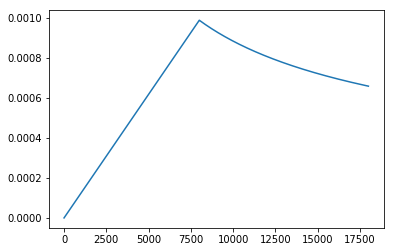

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
scheduler = LRScheduler(D_MODEL, WARMUP_STEPS, LEARNING_RATE)
learning_rates = [scheduler.lr()
                  for _ in range(WARMUP_STEPS+10_000)]
plt.plot(learning_rates)

In [63]:
from model import Transformer
model = Transformer(
    n_heads=N_HEADS,
    encoder_layers=N_LAYERS,
    decoder_layers=N_LAYERS,
    d_model=D_MODEL,
    vocab_size=VOCAB_SIZE,
    sequence_len=SENTENCE_LEN,
    dropout=DROPOUT,
    output_activation=OUTPUT_ACTIVATION)

In [64]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
encoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    15360000    encoder_input[0][0]              
                                                                 decoder_input[0][0]              
__________________________________________________________________________________________________
positional_encoding_3 (Position (None, None, 512)    0           embedding[0][0]                  
          

In [65]:
TARGET_PLACEHOLDER = tf.placeholder(dtype='int32', shape=(None, SENTENCE_LEN))
model.compile(
    loss=LOSS,
    optimizer=OPTIMIZER,
    metrics=METRICS,
    target_tensors=[TARGET_PLACEHOLDER])

In [66]:
# print loss values for reference
def display_loss_reference():
    format_ = 'perplexity: %20s\tentropy: %20s'
    upper_limit = np.log(VOCAB_SIZE)
    print(format_ % (np.exp(upper_limit), upper_limit))
    for i in reversed(range(int(np.floor(upper_limit))+1)):
        print(format_ % (np.exp(i), i))
display_loss_reference()

perplexity:   30000.000000000007	entropy:   10.308952660644293
perplexity:   22026.465794806718	entropy:                   10
perplexity:    8103.083927575384	entropy:                    9
perplexity:   2980.9579870417283	entropy:                    8
perplexity:   1096.6331584284585	entropy:                    7
perplexity:    403.4287934927351	entropy:                    6
perplexity:    148.4131591025766	entropy:                    5
perplexity:   54.598150033144236	entropy:                    4
perplexity:   20.085536923187668	entropy:                    3
perplexity:     7.38905609893065	entropy:                    2
perplexity:    2.718281828459045	entropy:                    1
perplexity:                  1.0	entropy:                    0


In [80]:
model.fit_generator(
    iter(epoch),
#     epochs=N_EPOCHS,
    steps_per_epoch=N_EPOCHS,
    validation_data=iter(test_epoch),
    validation_steps=1,
    callbacks=CALLBACKS)

Epoch 1/1


InvalidArgumentError: indices[4,34] = 32700 is not in [0, 30000)
	 [[Node: embedding_5/embedding_lookup = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, _class=["loc:@embedding_4/embeddings"], validate_indices=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding_4/embeddings/read, embedding_5/Cast)]]

Caused by op 'embedding_5/embedding_lookup', defined at:
  File "/usr/local/homebrew/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/homebrew/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-63-373d198fb3bf>", line 10, in <module>
    output_activation=OUTPUT_ACTIVATION)
  File "../model.py", line 54, in __init__
    self.encoder_embedding, self.decoder_embedding, self.embedding_weights = self.init_embeddings()
  File "../model.py", line 78, in init_embeddings
    decoder_embedding = embedding(self.decoder_input)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/keras/engine/base_layer.py", line 460, in __call__
    output = self.call(inputs, **kwargs)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/keras/layers/embeddings.py", line 139, in call
    out = K.gather(self.embeddings, inputs)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 1225, in gather
    return tf.nn.embedding_lookup(reference, indices)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/tensorflow/python/ops/embedding_ops.py", line 325, in embedding_lookup
    transform_fn=None)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/tensorflow/python/ops/embedding_ops.py", line 150, in _embedding_lookup_and_transform
    result = _clip(_gather(params[0], ids, name=name), ids, max_norm)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/tensorflow/python/ops/embedding_ops.py", line 54, in _gather
    return array_ops.gather(params, ids, name=name)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 2585, in gather
    params, indices, validate_indices=validate_indices, name=name)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1864, in gather
    validate_indices=validate_indices, name=name)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/Users/dgates/venvs/py3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): indices[4,34] = 32700 is not in [0, 30000)
	 [[Node: embedding_5/embedding_lookup = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, _class=["loc:@embedding_4/embeddings"], validate_indices=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding_4/embeddings/read, embedding_5/Cast)]]
